In [ ]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb
# %cd /content/drive/Shareddrives/BUAT\ DIEGO/Data-retail-2015-2022-keluar/
%cd /content/drive/MyDrive/data-retail

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data-retail


In [ ]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading data

In [ ]:
# df2015 = pd.read_csv('./data-2015-renew.csv')
df2016 = pd.read_csv('./data-2016-renew.csv', parse_dates=['tgl'])
df2017 = pd.read_csv('./data-2017-renew.csv', parse_dates=['tgl'])
df2018 = pd.read_csv('./data-2018-renew.csv', parse_dates=['tgl'])
df2019 = pd.read_csv('./data-2019-renew.csv', parse_dates=['tgl'])
df2020 = pd.read_csv('./data-2020-renew.csv', parse_dates=['tgl'])
df2021 = pd.read_csv('./data-2021-renew.csv', parse_dates=['tgl'])
df2022 = pd.read_csv('./data-2022-renew.csv', parse_dates=['tgl'])

In [ ]:
product_list = ['011747233057', '011747234207', '055500130221']

selected_data_2021 = df2021[df2021['barcode'].isin(product_list)].reset_index(drop=True)
namabarang = ['DUA KELINCI KCG.GRG 10*750GR', 'DOLPIN GARAM 1000GR*12', 'SOS P.LANTAI ORANGE 750ML REFF']

In [ ]:
# drop unnecessary column

# df2016 = df2016.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2017 = df2017.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2018 = df2018.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2019 = df2019.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2020 = df2020.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2021 = df2021.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2022 = df2022.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)

In [ ]:
df = pd.concat([df2017, df2018, df2019, df2020, df2021, df2022])
# df = pd.concat([df2021, df2022])
df['year_month'] = df['tgl'].apply(lambda x: x.strftime('%Y-%m')).astype(str)
df['month_yr'] = df['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)
# 2017-2021
df['month_yr'] = df['month_yr'].map({'01-17':0,'02-17':1,'03-17':2,'04-17':3,'05-17':4,'06-17':5,'07-17':6,'08-17':7,'09-17':8,'10-17':9,'11-17':10,'12-17':11,
                                          '01-18':12,'02-18':13,'03-18':14,'04-18':15,'05-18':16,'06-18':17,'07-18':18,'08-18':19,'09-18':20,'10-18':21,'11-18':22,'12-18':23,
                                          '01-19':24,'02-19':25,'03-19':26,'04-19':27,'05-19':28,'06-19':29,'07-19':30,'08-19':31,'09-19':32,'10-19':33,'11-19':34,'12-19':35,
                                          '01-20':36,'02-20':37,'03-20':38,'04-20':39,'05-20':40,'06-20':41,'07-20':42,'08-20':43,'09-20':44,'10-20':45,'11-20':46,'12-20':47,
                                          '01-21':48,'02-21':49,'03-21':50,'04-21':51,'05-21':52,'06-21':53,'07-21':54,'08-21':55,'09-21':56,'10-21':57,'11-21':58,'12-21':59,
                                          '01-22':60,'02-22':61,'03-22':62})
print(f"Min date from data set: {df['tgl'].min().date()}")
print(f"Max date from data set: {df['tgl'].max().date()}")

Min date from data set: 2017-01-01
Max date from data set: 2022-03-01


In [ ]:
df_train = pd.concat([df2017, df2018, df2019, df2020, df2021])
df_train['year_month'] = df_train['tgl'].apply(lambda x: x.strftime('%Y-%m')).astype(str)
df_train['month_yr'] = df_train['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)
# 2017-2021
df_train['month_yr'] = df_train['month_yr'].map({'01-17':0,'02-17':1,'03-17':2,'04-17':3,'05-17':4,'06-17':5,'07-17':6,'08-17':7,'09-17':8,'10-17':9,'11-17':10,'12-17':11,
                                          '01-18':12,'02-18':13,'03-18':14,'04-18':15,'05-18':16,'06-18':17,'07-18':18,'08-18':19,'09-18':20,'10-18':21,'11-18':22,'12-18':23,
                                          '01-19':24,'02-19':25,'03-19':26,'04-19':27,'05-19':28,'06-19':29,'07-19':30,'08-19':31,'09-19':32,'10-19':33,'11-19':34,'12-19':35,
                                          '01-20':36,'02-20':37,'03-20':38,'04-20':39,'05-20':40,'06-20':41,'07-20':42,'08-20':43,'09-20':44,'10-20':45,'11-20':46,'12-20':47,
                                          '01-21':48,'02-21':49,'03-21':50,'04-21':51,'05-21':52,'06-21':53,'07-21':54,'08-21':55,'09-21':56,'10-21':57,'11-21':58,'12-21':59})
print(f"Min date from data set: {df_train['tgl'].min().date()}")
print(f"Max date from data set: {df_train['tgl'].max().date()}")

Min date from data set: 2017-01-01
Max date from data set: 2021-12-31


#Select Kategori

In [ ]:
# print("kodekategori 2016: ", df2016['kodekategori'].unique())
# print("kategori 2016: ", df2016['kategori'].unique())
# print("2017: ", df2017['kategori'].unique())
# print("2018: ", df2018['kategori'].unique())
# print("2019: ", df2019['kategori'].unique())
# print("2020: ", df2020['kategori'].unique())

In [ ]:
# get unique kategori value

group_kategori2016 = df2016.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2017 = df2017.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2018 = df2018.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2019 = df2019.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2020 = df2020.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2021 = df2021.groupby('kodekategori')['kategori'].unique().reset_index()

# pdList = [group_kategori2016, group_kategori2017, group_kategori2018, group_kategori2019]
pdList = [group_kategori2016, group_kategori2017, group_kategori2018, group_kategori2019, group_kategori2020, group_kategori2021]

new_kategori = pd.concat(pdList).reset_index(drop=True)
new_kategori['kodekategori'] = new_kategori['kodekategori'].astype(float)
new_kategori['kategori'] = new_kategori['kategori'].astype(str)

clean_kategori = new_kategori.drop_duplicates(subset=['kodekategori']).reset_index(drop=True)

In [ ]:
display(clean_kategori)

,kodekategori,kategori
0,101.00,['Baby Needs']
1,102.00,['Mens Care (2)']
2,103.00,['Healt & Beauty Care (3)']
3,104.00,['Kids Care (4)']
4,105.00,['Cleaning (5)']
5,106.00,['Homes (6)']
6,107.00,['Electronic & Tool kits (7)']
7,108.00,['Automotive (8)']
8,109.00,['Stationery (9)']
9,110.00,['Toys (10)']


In [ ]:
# initiate the kategori list that will removed from dataset

kategori_remove_name = ["Fresh Food (6)", "Roti dan Kue (Bread & Cake)", "Sarapan Pagi (Breakfast)", "Makanan Mentah (Raw Food)", "Ice", "Makanan Masak (Cooked Food)", "Buah (Fruit)", "Sayur (Vegetable)", "Harian (Daily)", "Beku (Frozen)", "Telur (Egg)", "Produk Siap Makan (Ready To Eat)", "Daging Merah (Red Meat)", "Daging Putih (White Meat)"]
kategori_remove_list = ["206.00", "10104.00", "10105.00", "10108.00", "10109.00", "10110.00", "20101.00", "20201.00", "20502.00", "20503.00", "20504.00", "20601.00", "20301.00", "20302.00"]

In [ ]:
# drop unnecessary kategori

# init = df_train.copy()
# init = init[~init['kategori'].isin(kategori_remove_name)].reset_index(drop=True)
df_train = df_train[~df_train['kategori'].isin(kategori_remove_name)].reset_index(drop=True)

# EDA 1

In [ ]:
barcode_u = len(pd.unique(df_train['barcode']))
jenis_u = len(pd.unique(df_train['kodejenis']))
kategori_u = len(pd.unique(df_train['kodekategori']))
print('Unique Barcode:',barcode_u)
print('Unique Kode Jenis:',jenis_u)
print('Unique Kode Kategori:',kategori_u)

Unique Barcode: 30455
Unique Kode Jenis: 504
Unique Kode Kategori: 103


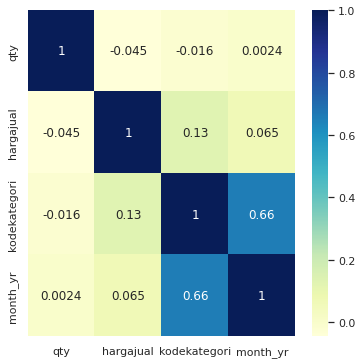

In [ ]:
corr = df_train.corr()
top_corr_features = corr.index[abs(corr["qty"])>0]

plt.figure(figsize=(6,6))
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="YlGnBu")

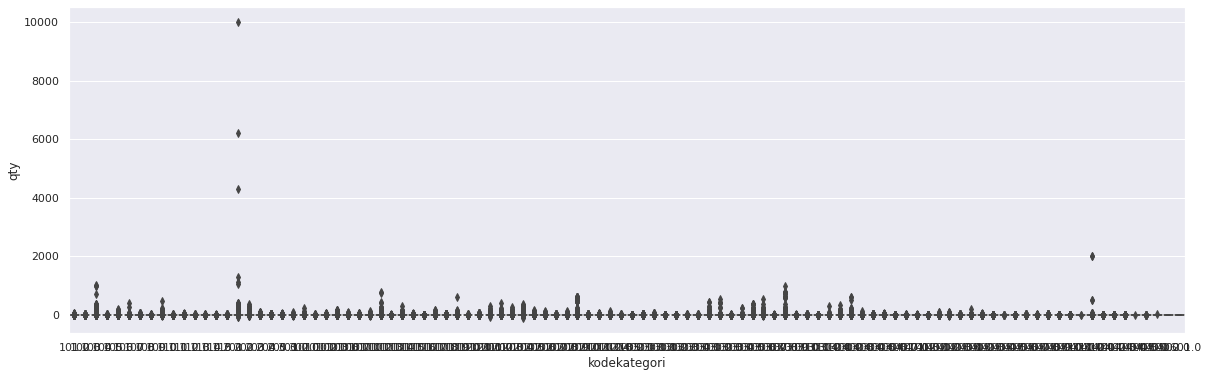

In [ ]:
sns.set(rc={'figure.figsize':(20,6)})
sns.boxplot(x='kodekategori', y='qty', data=df_train)

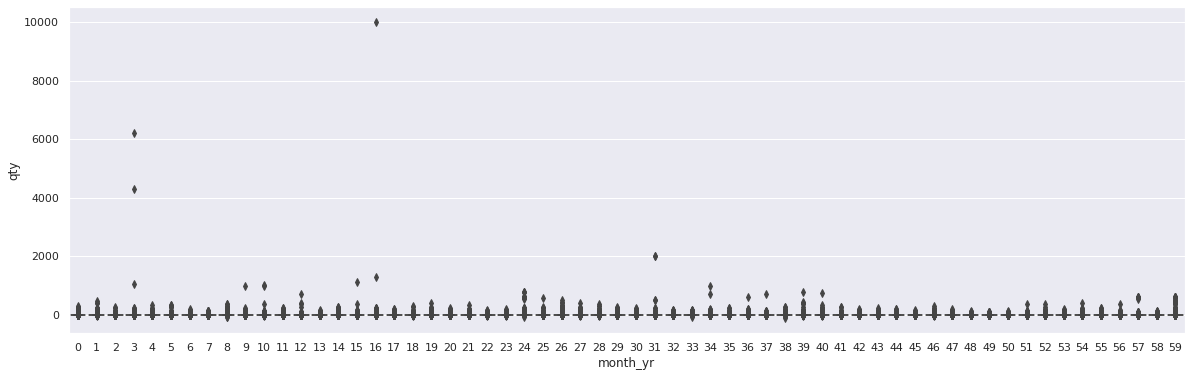

In [ ]:
sns.set(rc={'figure.figsize':(20,6)})
sns.boxplot(x='month_yr', y='qty', data=df_train)

In [ ]:
# plt.scatter(df_train['hargajual'], df_train['qty'], color = "red")
# plt.show()

In [ ]:
35+12

47

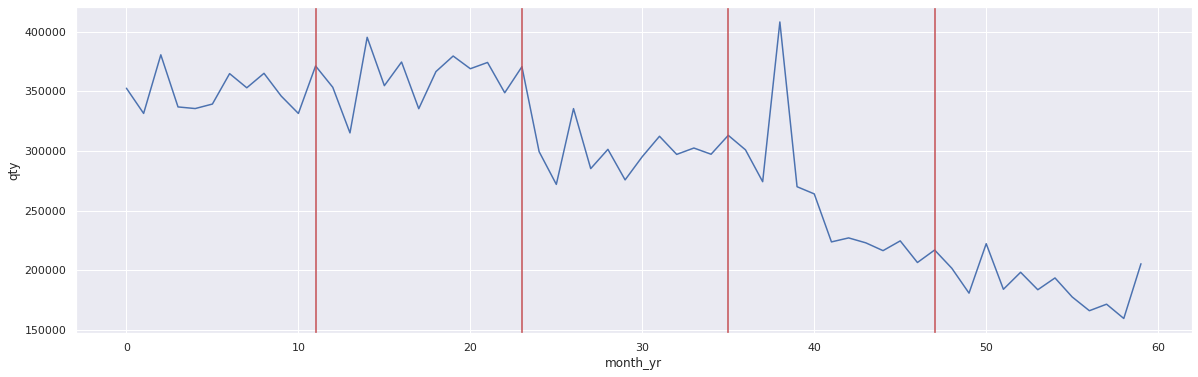

In [ ]:
df_train_plot = df_train.groupby(['month_yr'],as_index=False).sum()
df_train_plot.head()
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(x='month_yr', y='qty', data=df_train_plot)
plt.axvline(x=11, ymin=0, ymax=1, color='r')
plt.axvline(x=23, ymin=0, ymax=1, color='r')
plt.axvline(x=35, ymin=0, ymax=1, color='r')
plt.axvline(x=47, ymin=0, ymax=1, color='r')

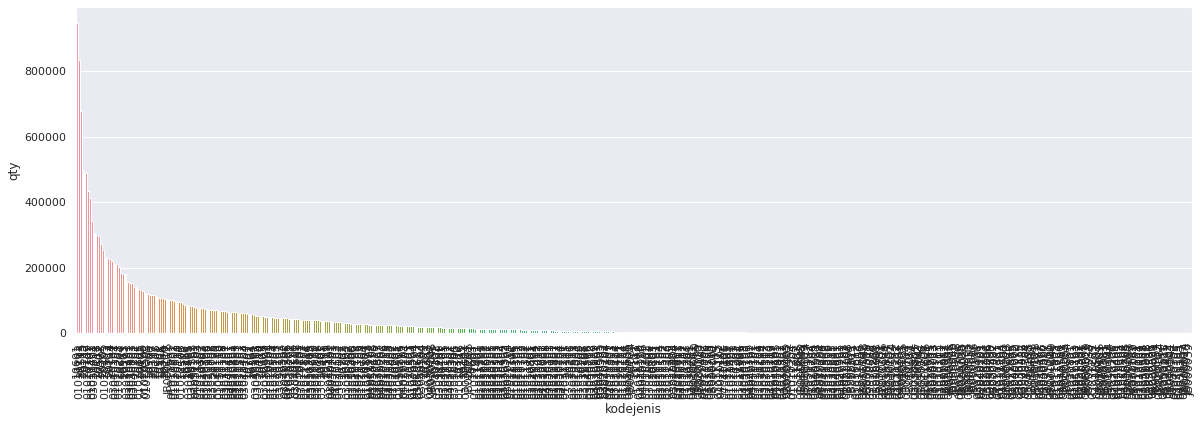

In [ ]:
df_train_s = df_train.groupby(['kodejenis'],as_index=False).sum().sort_values("qty", ascending=False)
sns.set(rc={'figure.figsize':(20,6)})
sns.barplot(x='kodejenis', y='qty', data=df_train_s, )
plt.xticks(rotation=90)
plt.show()

In [ ]:
# df_train_p = df_train.groupby(['hargajual'],as_index=False).sum()
# sns.set(rc={'figure.figsize':(15,6)})
# sns.lineplot(x='hargajual', y='qty', data=df_train_p)

In [ ]:
# Handling Outliers
# df = df[df['hargajual'] < 6000]
# df = df[df['qty'] < 4000]

In [ ]:
# drop rows wich contains negative and zero values
df_train[df_train['qty']<0].count()

tgl             1108
satuan          1108
qty             1108
hargajual       1108
barcode         1108
kodejenis       1108
kodekategori    1108
kategori        1108
year_month      1108
month_yr        1108
dtype: int64

In [ ]:
# df_train = df_train[df_train['qty']>0]

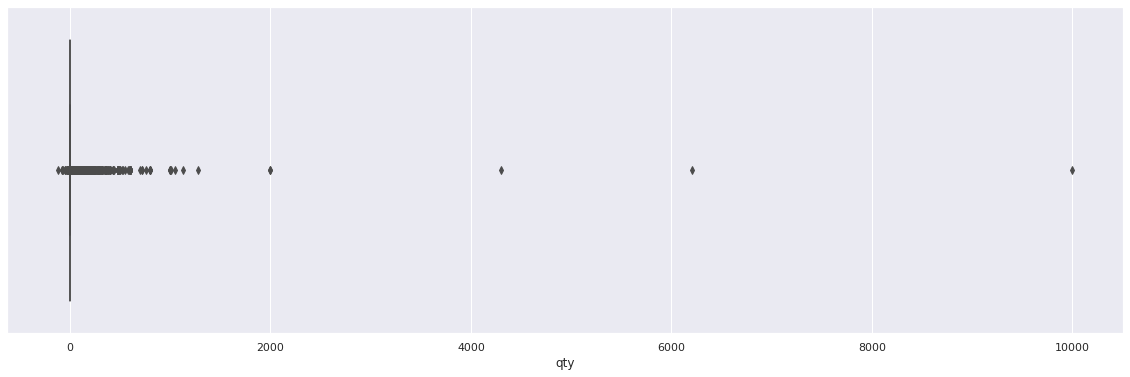

In [ ]:
# reviewing the outlier of the number of products sold
ax = sns.boxplot(df_train['qty'])

In [ ]:
df_train.info() # 8616845 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11522540 entries, 0 to 11522539
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   tgl           datetime64[ns]
 1   satuan        object        
 2   qty           float64       
 3   hargajual     float64       
 4   barcode       object        
 5   kodejenis     object        
 6   kodekategori  float64       
 7   kategori      object        
 8   year_month    object        
 9   month_yr      int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 879.1+ MB


#EDA

In [ ]:
# overall sales trend
df_trend = df.groupby('year_month').sum()['qty'].reset_index()

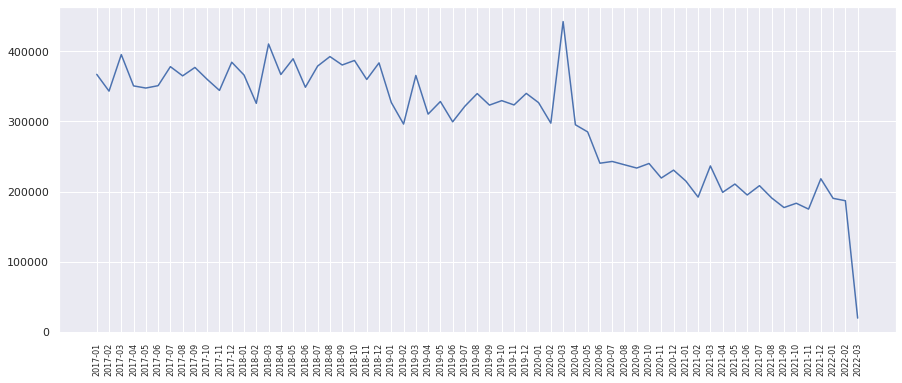

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_trend['year_month'], df_trend['qty'])
plt.xticks(rotation='vertical', size=8)
plt.show()

In [ ]:
df.nunique()

tgl             12606365
satuan                60
qty                 3663
hargajual           5245
barcode            31397
kodejenis            582
kodekategori         116
kategori             116
year_month            63
month_yr              63
dtype: int64

In [ ]:
# top 10 most selling poducts
prod_sales = pd.DataFrame(df.groupby('barcode').sum()['qty'])

In [ ]:
prod_sales = prod_sales.sort_values('qty', ascending=False)

In [ ]:
prod_sales[:10]

,qty
barcode,
56102,380521.56
56103,273262.30
089686010947,245563.00
8998866200301,173691.00
8992696404441,104711.00
56101,103481.00
8998866200325,84903.00
13662,78165.00
8886008101336,76402.00


In [ ]:
daily_sales = df.groupby("year_month", as_index=False)['qty'].sum()
# store_daily_sales = df.groupby(['store', 'year_month'], as_index=False)['sales'].sum()
item_daily_sales = df.groupby(['barcode', 'year_month'], as_index=False)['qty'].sum()

In [ ]:
# dail sales

daily_sales_sc = go.Scatter(x=daily_sales['year_month'], y=daily_sales['qty'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='year_month'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
%ls

data-2015-renew.csv  data-2022-renew.csv   df_train_raw.csv
data-2016-renew.csv  df_pred.csv           df_train_raw_new.csv
data-2017-renew.csv  df_pred_feb.csv       gru_model.h5
data-2018-renew.csv  df_pred_jan.csv       gru_model.sav
data-2019-renew.csv  df_train.csv          kategori_delist.csv
data-2020-renew.csv  df_train_feb_new.csv  test_result.csv
data-2021-renew.csv  df_train_jan_new.csv


In [ ]:
from keras.models import load_model

In [ ]:
jan = pd.read_csv('df_pred_jan.csv')
feb = pd.read_csv('df_pred_feb.csv')
gru_model = load_model('gru_model.h5')

In [ ]:
display(jan)
display(feb)

,barcode,0,1,2,3,4,5,6,7,8,9,10,11
0,11747233057,2.00,5.00,11.00,2.00,6.00,4.00,1.00,6.00,1.00,0.00,3.00,4.00
1,11747234207,17.00,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00
2,55500130221,10.00,17.00,19.00,9.00,10.00,8.00,16.00,10.00,4.00,13.00,7.00,3.00


,barcode,1,2,3,4,5,6,7,8,9,10,11,12
0,11747233057,5.00,11.00,2.00,6.00,4.00,1.00,6.00,1.00,0.00,3.00,4.00,0.00
1,11747234207,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00,12.00
2,55500130221,17.00,19.00,9.00,10.00,8.00,16.00,10.00,4.00,13.00,7.00,3.00,11.00


In [ ]:
# get data selected product list from 2021 and 2022 for ploting on website

product_list = ['011747233057', '011747234207', '055500130221']

# selected_data = jan[jan['barcode'].isin(product_list)].reset_index(drop=True)
# drop_jan = jan.drop(['barcode'], axis=1, inplace=True)
# drop_feb = feb.drop(['barcode'], axis=1, inplace=True)
drop_jan = jan.iloc[:, 1:]
drop_feb = feb.iloc[:, 1:]

display(drop_jan)
display(drop_feb)

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.00,5.00,11.00,2.00,6.00,4.00,1.00,6.00,1.00,0.00,3.00,4.00
1,17.00,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00
2,10.00,17.00,19.00,9.00,10.00,8.00,16.00,10.00,4.00,13.00,7.00,3.00


,1,2,3,4,5,6,7,8,9,10,11,12
0,5.00,11.00,2.00,6.00,4.00,1.00,6.00,1.00,0.00,3.00,4.00,0.00
1,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00,12.00
2,17.00,19.00,9.00,10.00,8.00,16.00,10.00,4.00,13.00,7.00,3.00,11.00


In [ ]:
bb = feb.columns
bb

Index(['barcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12'],
      dtype='object')

In [ ]:
jann = jan.T

In [ ]:
print(jan.iloc[:, :1].values)
print(jan.iloc[:, 1:].values)
print(jan.columns[1:].values)

[[11747233057]
 [11747234207]
 [55500130221]]
[[ 2.  5. 11.  2.  6.  4.  1.  6.  1.  0.  3.  4.]
 [17.  9. 12. 14. 12. 19. 14. 15. 14. 16. 20. 24.]
 [10. 17. 19.  9. 10.  8. 16. 10.  4. 13.  7.  3.]]
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11']


In [ ]:
X_jan = drop_jan.values.reshape((drop_jan.shape[0], drop_jan.shape[1], 1))
X_feb = drop_feb.values.reshape((drop_feb.shape[0], drop_feb.shape[1], 1))
jan_pred = gru_model.predict(X_jan)
feb_pred = gru_model.predict(X_feb)

In [ ]:
display(jan_pred)
display(feb_pred)

array([[ 3.6488318],
       [19.308125 ],
       [ 7.7799997]], dtype=float32)

array([[ 2.238058],
       [16.649498],
       [10.354751]], dtype=float32)

In [ ]:
# pred = pd.DataFrame({'jan_pred': jan_pred.flatten(), 'feb_pred': feb_pred.flatten()}, index=[0])
# pred

In [ ]:
last = feb.iloc[:, -1:] # get last column (12)

In [ ]:
feb['13'] = feb_pred

In [ ]:
# feb.info()
feb

,barcode,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11747233057,5.00,11.00,2.00,6.00,4.00,1.00,6.00,1.00,0.00,3.00,4.00,0.00,2.24
1,11747234207,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00,12.00,16.65
2,55500130221,17.00,19.00,9.00,10.00,8.00,16.00,10.00,4.00,13.00,7.00,3.00,11.00,10.35


In [ ]:
# transform data to get january and february 2022 sales product record
train_monthly = df[['tgl', 'month_yr', 'kodejenis', 'barcode', 'qty']].copy()
train_monthly = train_monthly.sort_values('tgl').groupby(['month_yr', 'kodejenis', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_yr', 'kodejenis', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt >= 0 and qty_cnt <= 50')

train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_yr').groupby(['barcode', 'kodejenis'])['qty_cnt'].shift(-1)
monthly_series = train_monthly.pivot_table(index=['barcode', 'kodejenis'], columns='month_yr',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_yr,barcode,kodejenis,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,00100809,01011601,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.69,15.35,20.38,13.80,7.03,8.72,11.13,11.36,16.29,7.11,10.22,11.02,12.75,10.78,27.13,32.93,18.57,11.34,13.62,12.14,8.19,4.22,2.76,3.97,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59,5.67,2.89,0.30
1,00100809,20604,8.04,10.89,15.34,14.70,15.63,20.85,11.92,16.73,14.30,14.26,11.93,11.39,14.40,12.55,20.04,15.83,14.22,19.72,20.78,19.90,12.00,11.78,14.68,14.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,00113731,02020101,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.60,3.46,4.43,4.75,6.09,4.07,5.42,4.27,4.89,3.76,3.62,2.89,3.61,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.75,0.78,0.45,1.72,0.32,0.87,0.00,0.00
3,00113731,20607,1.51,0.00,0.00,0.00,0.00,0.00,0.00,1.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,00125789,02010120,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.00,0.00,0.00,9.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# select product from selected barcode
monthly_series_list = ['011747233057', '011747234207', '055500130221']
monthly_series_select = monthly_series[monthly_series['barcode'].isin(product_list)].reset_index(drop=True)

In [ ]:
# pikirin lagi karena 1 barcode memiliki lebih dari 1 kodejenis, gunakan berdasarkan kodejenis atau kodekategori
monthly_series_select = monthly_series_select.drop_duplicates(subset=['barcode']) # drop duplicates barcode
# selected_product_2022 = monthly_series_select.iloc[:, 62:-1]
selected_product_2022 = monthly_series_select.iloc[:, :]
selected_product_2022.columns[61:-1].values

array([59, 60, 61], dtype=object)

In [ ]:
# daily sales by item
selected_product_2022_sc = []
for item in selected_product_2022['barcode'].unique():
    current_selected_product_2022 = selected_product_2022[(selected_product_2022['barcode'] == item)]
    selected_product_2022_sc.append(go.Scatter(x=current_selected_product_2022.columns[61:-1].values, y=current_selected_product_2022.iloc[:, 61:-1].values.flatten(), name=('Item %s' % item)))
    print(item)
print(selected_product_2022_sc)
layout = go.Layout(title='Item daily sales forecasting', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=selected_product_2022_sc, layout=layout)
iplot(fig)

011747233057
011747234207
055500130221
[Scatter({
    'name': 'Item 011747233057', 'x': array([59, 60, 61], dtype=object), 'y': array([4., 0., 3.])
}), Scatter({
    'name': 'Item 011747234207', 'x': array([59, 60, 61], dtype=object), 'y': array([24., 12.,  8.])
}), Scatter({
    'name': 'Item 055500130221', 'x': array([59, 60, 61], dtype=object), 'y': array([ 3., 11., 18.])
})]


In [ ]:
# grouping data
df_list = ['011747233057', '011747234207', '055500130221']
df_date = ['2022-01', '2022-03']

# df_select = df[df['barcode'].isin(product_list)].reset_index(drop=True)
filter1 = df['barcode'].isin(product_list)
filter2 = df['year_month'].isin(df_date)
df_select = df[filter1 & filter2]

In [ ]:
# daily_sales = df.groupby("year_month", as_index=False)['qty'].sum()
item_daily_sales_2022 = df_select.groupby(['barcode', 'year_month'], as_index=False)['qty'].sum()

In [ ]:
# dail sales

item_daily_sales_2022_sc = go.Scatter(x=item_daily_sales_2022['year_month'], y=item_daily_sales_2022['qty'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='year_month'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[item_daily_sales_2022_sc], layout=layout)
iplot(fig)

In [ ]:
# for name in jan['barcode'].values:
#     print(name)
#     for item in feb.values:
#       print(item)
  # print(item.iloc[:, :1].values)
  # print(item.iloc[:, 1:].values)
  # plt.plot(feb.columns, item, label=)

selected_data_sc = []
for item in jan['barcode'].unique():
    current_selected_data = jan[(jan['barcode'] == item)]
    selected_data_sc.append(go.Scatter(x=current_selected_data.columns[1:].values, y=current_selected_data.iloc[:, 1:].values.flatten(), name=('Item %s' % item)))
    selected_data_sc.append(go.Scatter(x=current_selected_data.columns[1:].values, y=current_selected_data.iloc[:, 1:].values.flatten(), name=('Pred Item %s' % item)))
    # selected_data_sc.append(go.Scatter(x=jan.columns[1:].values, y=current_selected_data.iloc[:, 1:].values.flatten(), name=('Item %s' % item)))
    print(item)
print(selected_data_sc)
layout = go.Layout(title='Item monthly sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=selected_data_sc, layout=layout)
iplot(fig)

11747233057
11747234207
55500130221
[Scatter({
    'name': 'Item 11747233057',
    'x': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
               dtype=object),
    'y': array([ 2.,  5., 11.,  2.,  6.,  4.,  1.,  6.,  1.,  0.,  3.,  4.])
}), Scatter({
    'name': 'Pred Item 11747233057',
    'x': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
               dtype=object),
    'y': array([ 2.,  5., 11.,  2.,  6.,  4.,  1.,  6.,  1.,  0.,  3.,  4.])
}), Scatter({
    'name': 'Item 11747234207',
    'x': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
               dtype=object),
    'y': array([17.,  9., 12., 14., 12., 19., 14., 15., 14., 16., 20., 24.])
}), Scatter({
    'name': 'Pred Item 11747234207',
    'x': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
               dtype=object),
    'y': array([17.,  9., 12., 14., 12., 19., 14., 15., 14., 16., 20., 24.])
}), Scatter({
    'name': 'It